In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [127]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        'correlation':0,

        'learning rate':0.01,
        'training epochs':5000,

        'training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop

        }

now = datetime.now()

# Data Prep

In [128]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [129]:
# use data with higher resolution
df = pd.read_excel('data_3nm.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [130]:
temp

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
0,364.787366,317.684838,313.810126,303.307879,314.323118,317.828320,318.557698,308.808121,309.953331,296.299100,318.002181
1,342.552920,335.048875,325.169322,323.807685,312.667938,307.509532,318.808960,312.412740,305.472749,315.420270,301.044787
2,314.150653,325.319947,330.529579,337.855852,336.525836,349.311552,336.370506,342.758437,344.195955,333.964029,357.969610
3,302.513193,306.523372,315.214925,315.629483,313.136991,312.378427,319.314782,302.018575,306.730069,310.949569,328.143455
4,332.142887,315.836569,320.947657,325.884656,338.307720,339.673089,334.705064,325.483513,321.166972,307.175291,335.245173
...,...,...,...,...,...,...,...,...,...,...,...
2195,327.359960,331.887028,335.439802,327.858751,329.905634,332.466652,323.482462,319.992829,334.062241,326.323524,359.801763
2196,354.311013,341.927755,337.451821,323.967416,330.097748,313.792185,317.839648,318.627400,331.026918,344.846164,348.886578
2197,345.013997,323.826484,315.340107,306.337376,314.184375,306.270021,304.561202,313.513715,321.161351,326.559357,338.238519
2198,309.706144,313.843492,332.026895,338.820759,345.317550,352.584174,339.603698,337.521742,337.254720,328.544064,342.340353


In [131]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [132]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.030522,0.041071,0.046751,0.038594,0.029359,0.031514,0.044740,0.043908,0.031703,...,2.255215,2.250856,2.246458,2.242043,2.237622,2.233144,2.228542,2.223762,2.218939,2.214334
1,0.023035,0.022440,0.029869,0.033942,0.028234,0.021514,0.022882,0.032111,0.031697,0.023014,...,1.636173,1.633204,1.630206,1.627196,1.624179,1.621120,1.617971,1.614691,1.611379,1.608225
2,0.033210,0.031840,0.041565,0.047073,0.039657,0.030226,0.031615,0.043466,0.043294,0.031684,...,4.265080,4.255842,4.246534,4.237201,4.227860,4.218417,4.208743,4.198740,4.188660,4.178998
3,0.013575,0.013062,0.017119,0.019424,0.016330,0.012460,0.013077,0.018064,0.017973,0.013144,...,2.689740,2.684366,2.678947,2.673510,2.668065,2.662553,2.656894,2.651024,2.645104,2.639444
4,0.026199,0.025317,0.033369,0.037874,0.031707,0.024162,0.025486,0.035419,0.035114,0.025598,...,3.023923,3.017753,3.011531,3.005289,2.999040,2.992716,2.986228,2.979503,2.972721,2.966234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.029561,0.028464,0.037357,0.042377,0.035572,0.027104,0.028480,0.039404,0.039142,0.028580,...,4.376826,4.367304,4.357712,4.348093,4.338467,4.328736,4.318769,4.308464,4.298080,4.288126
2196,0.037494,0.036416,0.048320,0.054880,0.045720,0.034819,0.036923,0.051657,0.051041,0.037082,...,3.737057,3.729141,3.721165,3.713165,3.705158,3.697059,3.688758,3.680167,3.671508,3.663214
2197,0.024724,0.024075,0.032048,0.036426,0.030301,0.023073,0.024538,0.034447,0.034000,0.024675,...,3.172314,3.165785,3.159202,3.152599,3.145989,3.139300,3.132439,3.125330,3.118162,3.111303
2198,0.030134,0.028889,0.037701,0.042697,0.035978,0.027433,0.028685,0.039423,0.039272,0.028752,...,3.383006,3.375964,3.368865,3.361745,3.354617,3.347406,3.340011,3.332353,3.324633,3.317242


In [133]:
# add noise to spectrum data
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

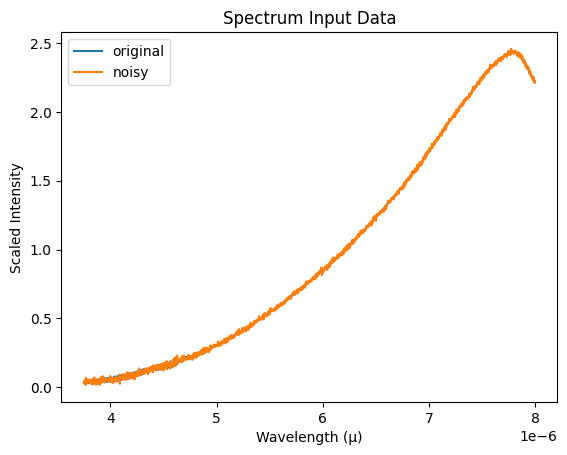

In [134]:
# create graph to view spectrum with and without noise
plt.title('Spectrum Input Data')
plt.plot(spec.iloc[0], label='original')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [135]:
# normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

scaler.fit(spec)
spec_scaled = scaler.transform(spec)

scaler.fit(spec_noisy)
spec_noisy_scaled = scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)


In [136]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.030522,0.041071,0.046751,0.038594,0.029359,0.031514,0.044740,0.043908,0.031703,...,2.255215,2.250856,2.246458,2.242043,2.237622,2.233144,2.228542,2.223762,2.218939,2.214334
1,0.023035,0.022440,0.029869,0.033942,0.028234,0.021514,0.022882,0.032111,0.031697,0.023014,...,1.636173,1.633204,1.630206,1.627196,1.624179,1.621120,1.617971,1.614691,1.611379,1.608225
2,0.033210,0.031840,0.041565,0.047073,0.039657,0.030226,0.031615,0.043466,0.043294,0.031684,...,4.265080,4.255842,4.246534,4.237201,4.227860,4.218417,4.208743,4.198740,4.188660,4.178998
3,0.013575,0.013062,0.017119,0.019424,0.016330,0.012460,0.013077,0.018064,0.017973,0.013144,...,2.689740,2.684366,2.678947,2.673510,2.668065,2.662553,2.656894,2.651024,2.645104,2.639444
4,0.026199,0.025317,0.033369,0.037874,0.031707,0.024162,0.025486,0.035419,0.035114,0.025598,...,3.023923,3.017753,3.011531,3.005289,2.999040,2.992716,2.986228,2.979503,2.972721,2.966234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.029561,0.028464,0.037357,0.042377,0.035572,0.027104,0.028480,0.039404,0.039142,0.028580,...,4.376826,4.367304,4.357712,4.348093,4.338467,4.328736,4.318769,4.308464,4.298080,4.288126
2196,0.037494,0.036416,0.048320,0.054880,0.045720,0.034819,0.036923,0.051657,0.051041,0.037082,...,3.737057,3.729141,3.721165,3.713165,3.705158,3.697059,3.688758,3.680167,3.671508,3.663214
2197,0.024724,0.024075,0.032048,0.036426,0.030301,0.023073,0.024538,0.034447,0.034000,0.024675,...,3.172314,3.165785,3.159202,3.152599,3.145989,3.139300,3.132439,3.125330,3.118162,3.111303
2198,0.030134,0.028889,0.037701,0.042697,0.035978,0.027433,0.028685,0.039423,0.039272,0.028752,...,3.383006,3.375964,3.368865,3.361745,3.354617,3.347406,3.340011,3.332353,3.324633,3.317242


In [137]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.548815,0.465783,-0.107774,0.687157,1.185808,-0.561369,0.191067,1.882802,0.936067,0.357203,...,-0.305234,-0.318857,-0.301254,-0.316928,-0.315334,-0.317839,-0.295053,-0.309960,-0.319277,-0.304651
1,-0.324989,0.015383,-0.029822,-0.577411,0.396916,0.727939,0.032326,-0.623097,0.302884,0.212766,...,-0.789448,-0.790987,-0.806232,-0.795116,-0.796252,-0.800802,-0.802642,-0.799549,-0.804976,-0.802127
2,1.028199,-0.126664,-0.587641,-0.169098,-0.044226,0.809670,-0.566780,0.702687,1.032453,0.999561,...,1.274353,1.282296,1.278770,1.283728,1.285018,1.269793,1.280941,1.270085,1.263457,1.270689
3,-0.501809,-2.122587,-1.707409,-1.039970,-0.959373,-0.711649,-2.455560,-0.943405,-1.299166,-1.667574,...,0.030492,0.019552,0.029339,0.018450,0.029921,0.030250,0.023540,0.035071,0.021774,0.043480
4,-0.444209,-0.029617,-0.957245,-0.016015,-0.055589,-0.211186,0.658531,0.733544,-0.989827,1.262195,...,0.285617,0.307074,0.305799,0.296530,0.307145,0.303311,0.294233,0.314019,0.277147,0.291815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-1.023370,-0.652817,0.474400,0.157901,-0.269783,1.003477,0.625893,-0.193682,-0.029276,-0.004640,...,1.371246,1.359972,1.356027,1.357460,1.369878,1.362899,1.362618,1.373903,1.362435,1.364873
2196,1.189102,1.766340,1.491742,0.439950,0.356893,0.375037,-0.090881,0.289239,-0.511769,0.796033,...,0.867627,0.857290,0.863834,0.849423,0.851537,0.855619,0.858369,0.861734,0.856665,0.852289
2197,1.009331,1.024839,0.231674,-0.835503,-0.562962,-1.045149,-1.087021,-0.266847,0.861979,0.019694,...,0.408043,0.404412,0.408786,0.405435,0.417059,0.407252,0.421989,0.405950,0.415065,0.393367
2198,1.468770,1.368965,1.116220,1.062443,-0.449572,-0.293343,0.487951,0.377430,1.269481,0.221858,...,0.568987,0.585108,0.569922,0.581199,0.579614,0.575660,0.581148,0.575627,0.595603,0.571800


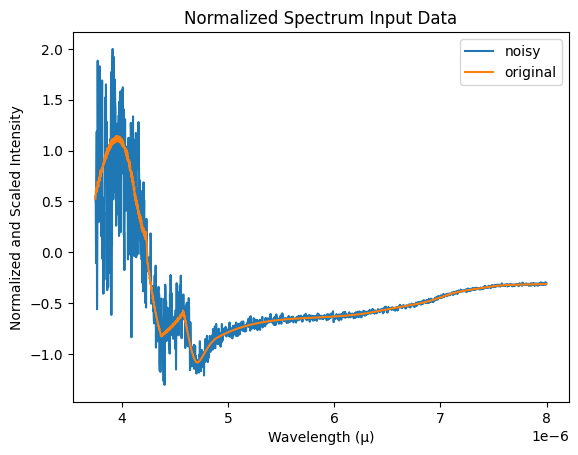

In [138]:
# create graph to view normalized spectrum data with and without noise
plt.title('Normalized Spectrum Input Data')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [139]:
# split data
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [140]:
spec_train

tensor([[-0.4667, -0.9872, -1.5900,  ..., -1.1178, -1.1365, -1.1166],
        [ 0.1963, -0.6751,  1.0634,  ...,  1.6849,  1.6857,  1.6769],
        [-0.6630,  0.5442, -1.8354,  ..., -0.6925, -0.6855, -0.6895],
        ...,
        [-1.4431, -1.7910, -2.0210,  ..., -1.0016, -1.0068, -1.0073],
        [ 1.5818,  1.7243,  0.7667,  ...,  0.2005,  0.2187,  0.2186],
        [-0.0673, -0.4146,  0.0729,  ...,  1.4554,  1.4673,  1.4678]])

In [141]:
temp_train

tensor([[279.2097, 291.1372, 304.6712,  ..., 309.0874, 307.9146, 287.3898],
        [284.7944, 309.4465, 334.0897,  ..., 303.7473, 311.2545, 366.0722],
        [303.5786, 296.0121, 320.1395,  ..., 300.9098, 290.0527, 305.2413],
        ...,
        [293.5930, 300.5022, 312.8386,  ..., 306.9922, 292.7501, 293.1349],
        [337.4347, 345.6631, 344.0024,  ..., 324.8639, 323.7931, 333.0087],
        [293.4902, 286.4892, 303.6414,  ..., 345.2938, 341.2333, 361.8345]])

# Model Design

In [142]:
# create model that inputs spectrum data and use a bottleneck to output temperature data
# (45, 45) , (65, 65), (70, 70) all work about the same
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 45) 
        self.lin_fin = nn.Linear(45, output_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        pred_temp = self.lin_fin(x)
        return pred_temp
    

In [143]:
# define variables
_, input_size = spec_noisy_scaled_df.shape
_, output_size = temp.shape

# define model
model = Net(input_size, output_size)

# define pred_temp by passing spectrum training data through the model
pred_temp = model(spec_train)


# Training Loop

In [144]:
def train_model(model, spec_train):
    print('\nTRAINING')

    loss_list = []
    
    loss_sum = 0

    num_epochs = args['training epochs']
    criterion = args['training criterion']
    optimizer = args['optimizer'](model.parameters(), lr=args['learning rate'])

    for epoch in range(num_epochs):
        pred_temp = model(spec_train)

        # calculate loss
        loss = criterion(temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            loss_sum += loss.item()

        loss_list.append(loss.item())

        # print loss every 10% of epochs
        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f'Epoch: {epoch + 1}, Loss = {loss}')

    print(f'epoch: {epoch + 1}, loss = {loss}')

    # find average training loss
    avg_training_loss = loss_sum / (num_epochs - 100)
    print(f'\nAverage training loss (across all layers): {avg_training_loss}')
    
    return loss_list


loss_list = train_model(model, spec_train)




TRAINING
Epoch: 500, Loss = 3.6239285469055176
Epoch: 1000, Loss = 3.402462959289551
Epoch: 1500, Loss = 3.3768160343170166
Epoch: 2000, Loss = 3.37048602104187
Epoch: 2500, Loss = 3.36716890335083
Epoch: 3000, Loss = 3.3648321628570557
Epoch: 3500, Loss = 3.3627076148986816
Epoch: 4000, Loss = 3.3608102798461914
Epoch: 4500, Loss = 3.3590621948242188
Epoch: 5000, Loss = 3.357490301132202
epoch: 5000, loss = 3.357490301132202

Average training loss (across all layers): 3.460812455245427


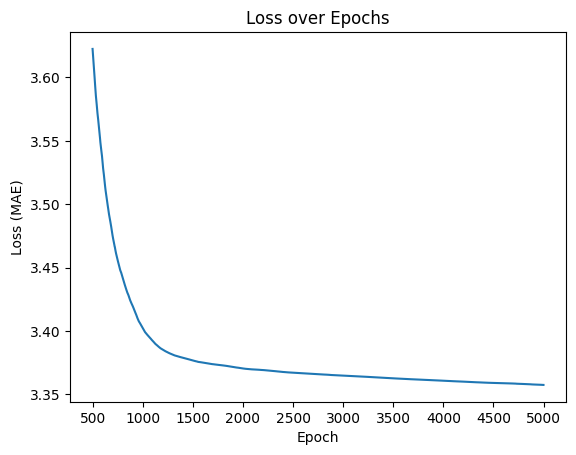

In [145]:
# plot loss over epochs

# add 500 to x-axis
x_values = range(500, args['training epochs'])
plt.plot(x_values, loss_list[500:])
plt.xticks(range(500, args['training epochs'] + 500, args['training epochs'] // 10))

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

# Testing

In [146]:
# test data
pred_temp = model(spec_test)

In [147]:
# unscale spectrum data
spec_test = scaler.inverse_transform(spec_test.detach().numpy())

In [148]:
# plot predicted vs actual graphs for random set of test data
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    

    x_values = range(1, 12)

    plt.plot(x_values, pred, 'ro', label='predicted')
    plt.plot(x_values, actual, 'b', label='actual')
    
    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i+1, pred[i]+2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')


    plt.xticks(range(1, 12))
    plt.legend()
    plt.show()

Average test loss: 4.140938679508598
Test losses of layers: [4.1627194028912164, 7.4565036195697205, 4.124157899798769, 3.7895251649798767, 5.0928192138671875, 4.552884882146662, 4.865801400849313, 3.78123076467803, 3.843015266187263, 2.5966691913026754, 1.2849986683238637]


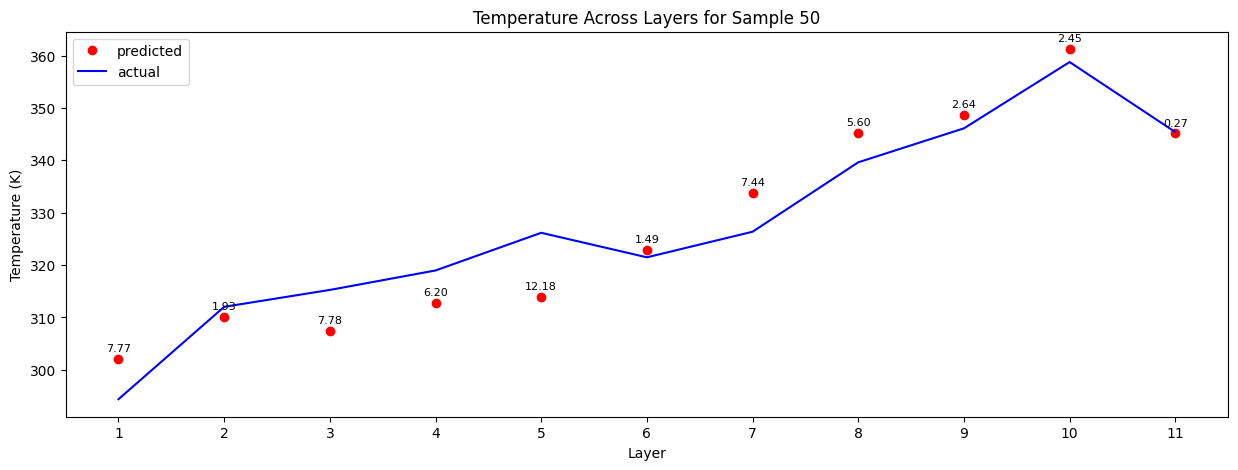

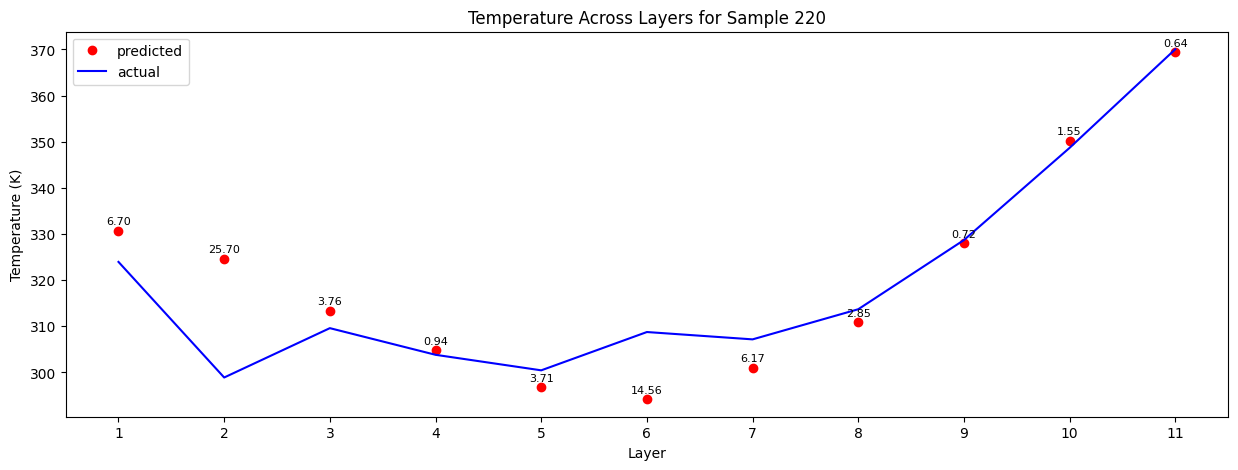

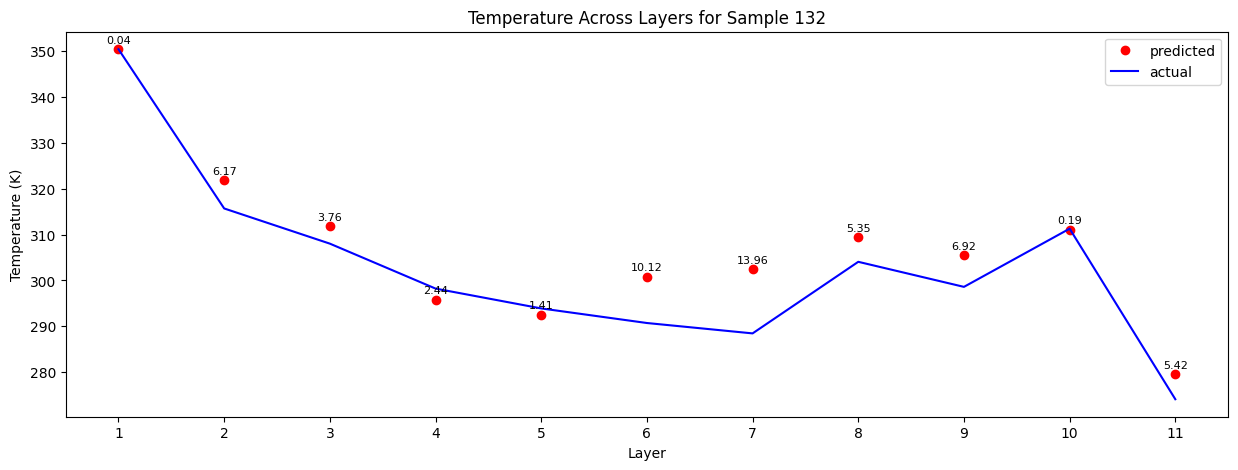

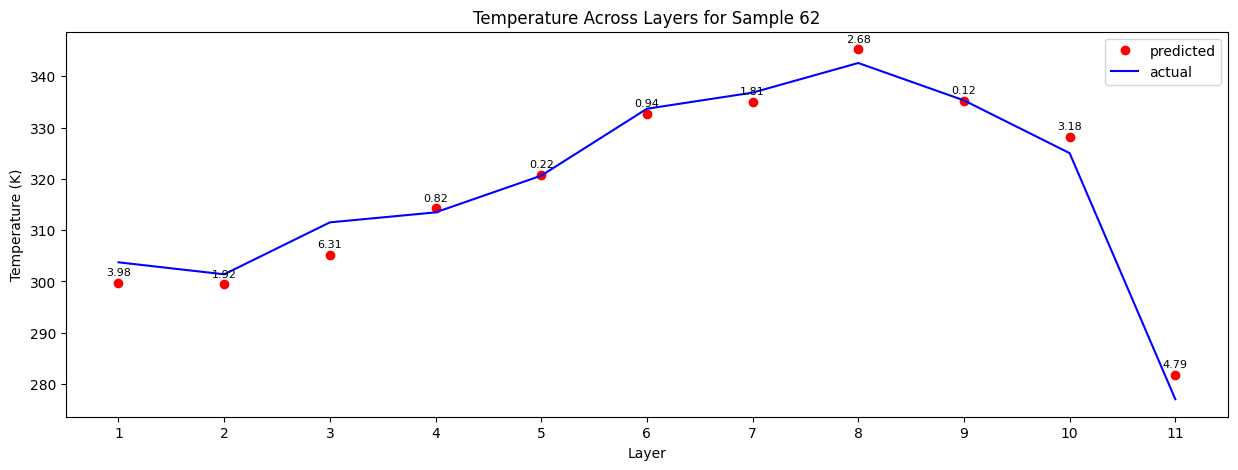

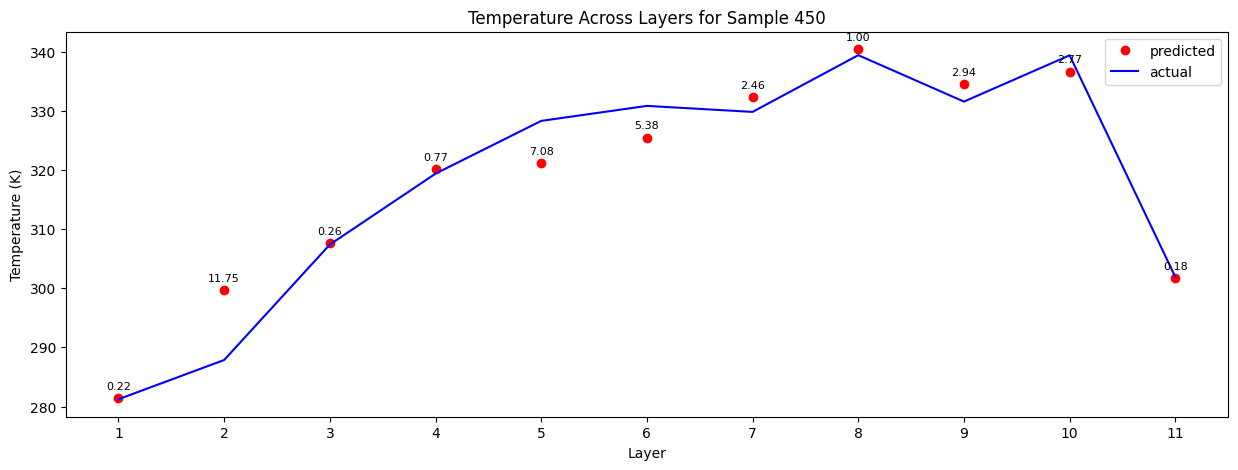

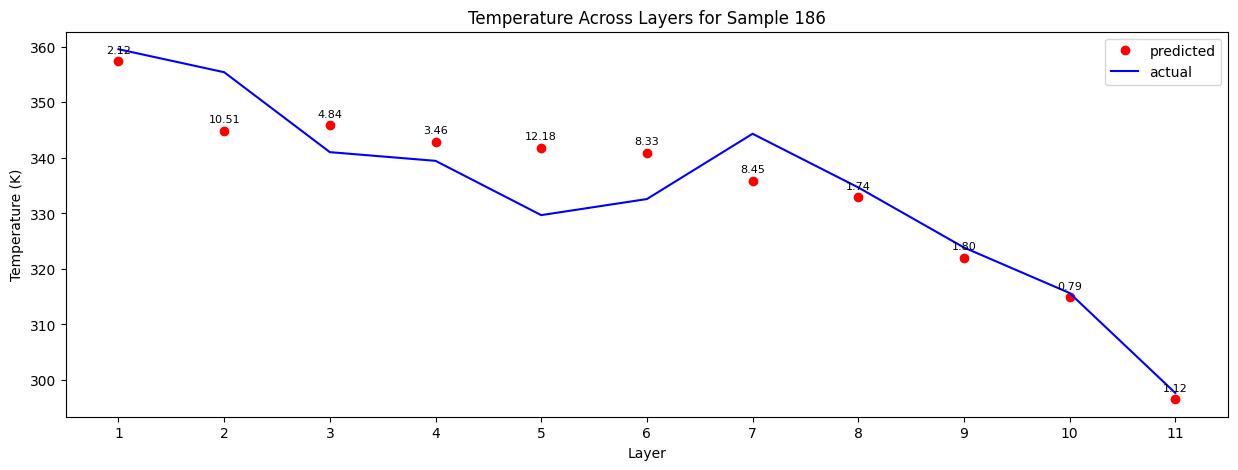

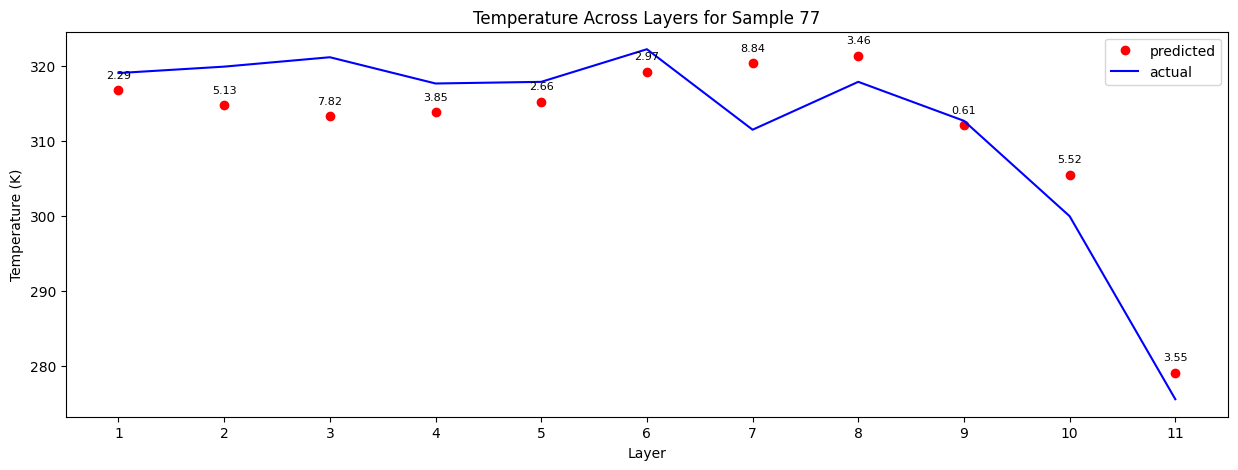

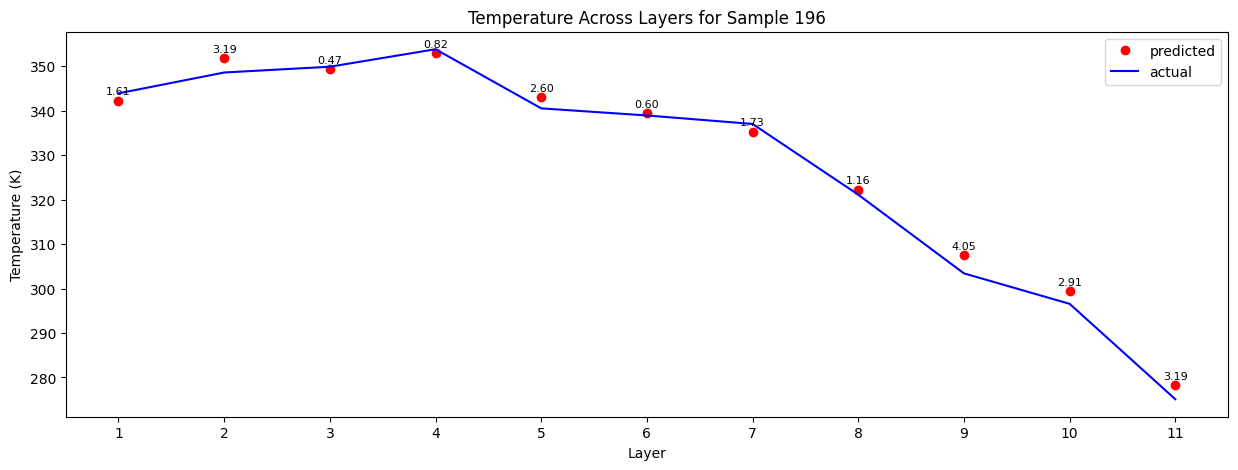

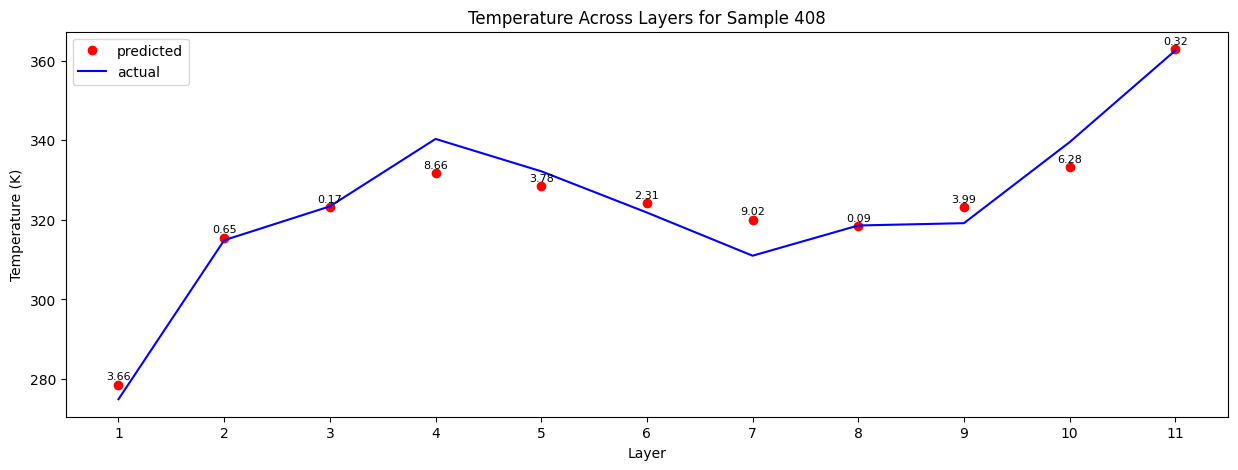

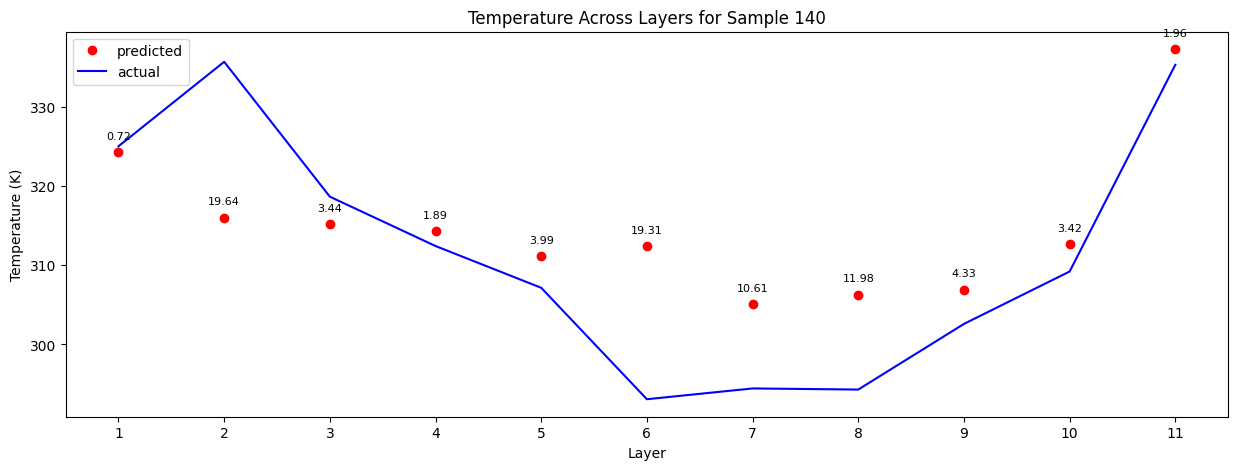

In [149]:
import random

# for avg loss
total_test_loss = 0
num_losses = 0 

# for per layer loss
num_graphs = 10
indices = []
layer_test_losses = [0] * 11


with torch.no_grad():
    for i in range(len(pred_temp)):
        # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            l1_loss = abs(pred_temp[i][layer] - temp_test[i][layer]).item()
            layer_test_losses[layer] += l1_loss

            # calculate avg test loss
            total_test_loss += l1_loss
            num_losses += 1

            avg_test_loss = total_test_loss / num_losses

    print(f'Average test loss: {avg_test_loss}')

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(layer_test_losses)):
        layer_test_losses[i] = layer_test_losses[i] / len(pred_temp)

    print(f'Test losses of layers: {layer_test_losses}')


    # pick random indices to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    # plot data for random set of entries
    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)

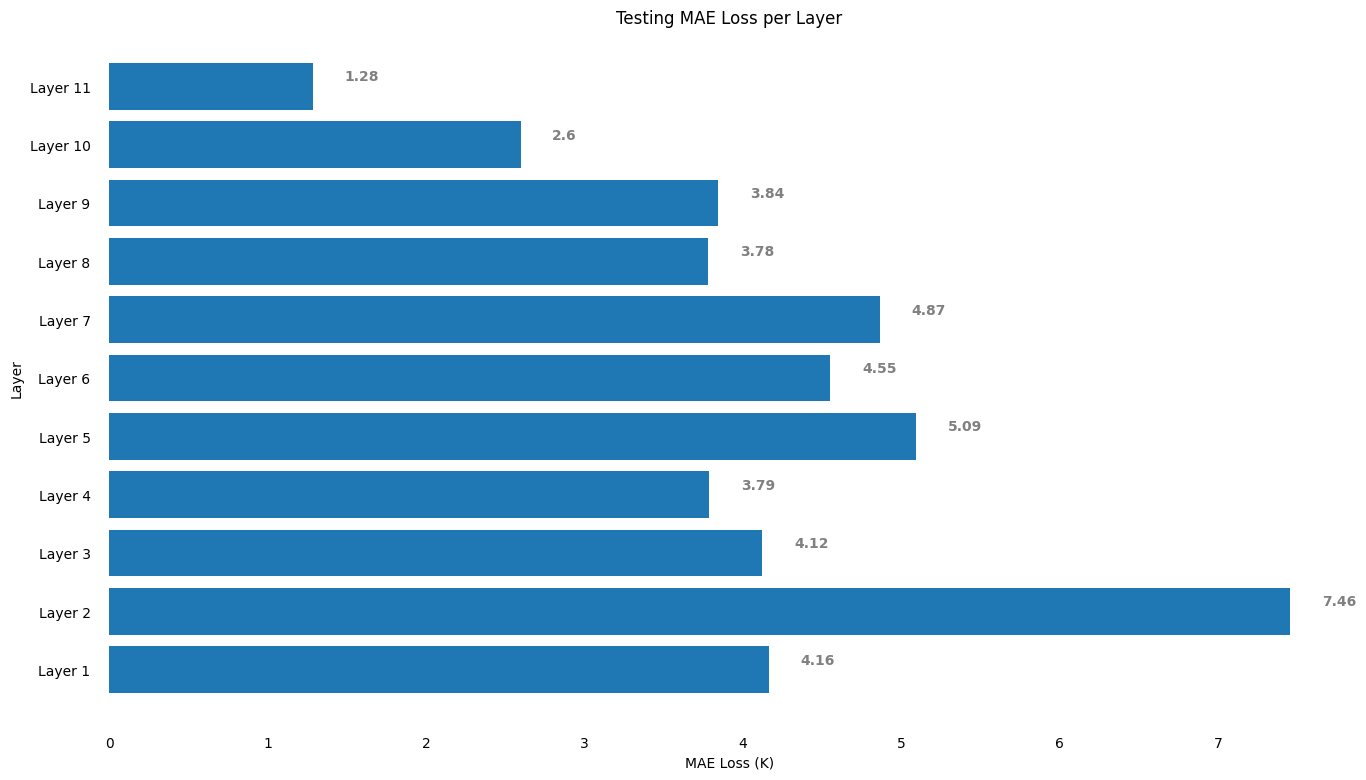

In [150]:
# plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, layer_test_losses)
 
# remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()